<h2 style='color:blue' align='center'>Transfer learning in image classification</h2>

**In this notebook we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand**

**Transfer learning**: It is using a pre-trained model as a foundation for further learning on a new task.In this the pre-trained model is used as a fixed feature extractor. The early layers of the model, which capture general features, are frozen, and only the later layers are modified and re-trained for the specific task.
    

In [4]:
# Install tensorflow_hub using pip install tensorflow_hub first

In [5]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Make predictions using ready made model (without any training)**

MobileNetV2 is a pre-trained deep learning models,it is used for image classification tasks. MobileNetV2 trained on ImageNet, there are 1,000 different classes representing a wide variety of objects

ImageNet is a large-scale dataset commonly used for training and evaluating image classification models. It consists of millions of labeled images spanning thousands of classes. MobileNetV2, when trained on ImageNet, learns to recognize and classify objects from these 1,000 predefined categories.

In [100]:
# Load the MobileNetV2 model from TensorFlow Hub
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([hub.KerasLayer(mobilenet_v2, input_shape=IMAGE_SHAPE + (3,))])

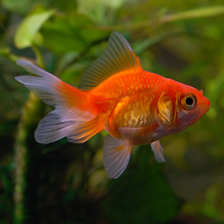

In [101]:
# Download a sample image (e.g.,goldfish )
gold_fish = Image.open("goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [102]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [103]:
gold_fish[np.newaxis, ...]

array([[[[0.28235294, 0.33333333, 0.07058824],
         [0.31372549, 0.37254902, 0.09019608],
         [0.34901961, 0.41960784, 0.11764706],
         ...,
         [0.32941176, 0.39215686, 0.00392157],
         [0.32156863, 0.38431373, 0.00392157],
         [0.30980392, 0.36862745, 0.        ]],

        [[0.28627451, 0.33333333, 0.08235294],
         [0.3254902 , 0.38039216, 0.10980392],
         [0.35294118, 0.42352941, 0.12941176],
         ...,
         [0.32156863, 0.38039216, 0.00392157],
         [0.31372549, 0.37254902, 0.00392157],
         [0.30196078, 0.36078431, 0.        ]],

        [[0.28627451, 0.33333333, 0.08627451],
         [0.31372549, 0.36862745, 0.10196078],
         [0.34509804, 0.41568627, 0.12941176],
         ...,
         [0.31764706, 0.37647059, 0.00392157],
         [0.30980392, 0.36862745, 0.00784314],
         [0.29803922, 0.35686275, 0.00392157]],

        ...,

        [[0.05490196, 0.10980392, 0.01568627],
         [0.05098039, 0.11372549, 0.01960784]

In [104]:
# Add a batch dimension and predict the class probabilities
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 945ms/step


(1, 1001)

In [105]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [106]:
# tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
image_labels = []
with open("F:\datasets\ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [107]:
image_labels[predicted_label_index]

'goldfish'

### Load flowers dataset

In [108]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

In [109]:
data_dir

'.\\datasets\\flower_photos'

In [110]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [111]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [112]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [113]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

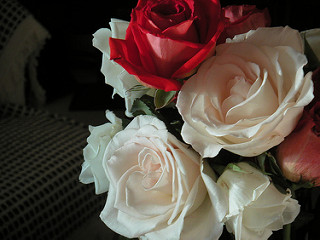

In [114]:
Image.open(str(roses[1]))

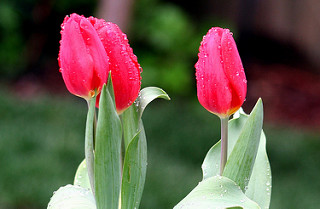

In [115]:
tulips = list(data_dir.glob('tulips/*'))
Image.open(str(tulips[0]))

**Read flowers images from disk into numpy array**

In [116]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [117]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [118]:
flowers_images_dict['roses'][:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

In [119]:
str(flowers_images_dict['roses'][0])

'datasets\\flower_photos\\roses\\10090824183_d02c613f10_m.jpg'

In [120]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [121]:
img.shape

(240, 179, 3)

In [122]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [123]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [124]:
X = np.array(X)
y = np.array(y)

**Train test split**

In [125]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

**Preprocessing: scale images**

In [126]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Make prediction using pre-trained model on new flowers dataset**

In [127]:
X[0].shape

(224, 224, 3)

In [128]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [129]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

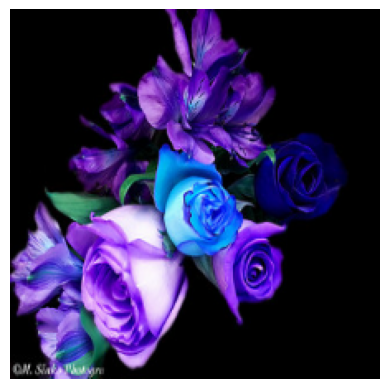

In [131]:
plt.axis('off')
plt.imshow(X[6])

In [135]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 0s 71ms/step


array([795, 880, 795], dtype=int64)

In [136]:
image_labels[795]

'shower curtain'

**Now take pre-trained model and retrain it using flowers images**

In [140]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [141]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_12 (KerasLayer  (None, 1001)              3540265   
 )                                                               
                                                                 
 dense (Dense)               (None, 5)                 5010      
                                                                 
Total params: 3545275 (13.52 MB)
Trainable params: 5010 (19.57 KB)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


In [147]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=25)

Epoch 1/25
86/86 [==============================] - 31s 316ms/step - loss: 0.0919 - acc: 0.9757
Epoch 2/25
86/86 [==============================] - 24s 280ms/step - loss: 0.0743 - acc: 0.9807
Epoch 3/25
86/86 [==============================] - 25s 290ms/step - loss: 0.0663 - acc: 0.9902
Epoch 4/25
86/86 [==============================] - 26s 303ms/step - loss: 0.0610 - acc: 0.9906
Epoch 5/25
86/86 [==============================] - 28s 320ms/step - loss: 0.0588 - acc: 0.9898
Epoch 6/25
86/86 [==============================] - 26s 299ms/step - loss: 0.0522 - acc: 0.9931
Epoch 7/25
86/86 [==============================] - 25s 290ms/step - loss: 0.0491 - acc: 0.9942
Epoch 8/25
86/86 [==============================] - 26s 303ms/step - loss: 0.0473 - acc: 0.9931
Epoch 9/25
86/86 [==============================] - 26s 300ms/step - loss: 0.0417 - acc: 0.9960
Epoch 10/25
86/86 [==============================] - 28s 321ms/step - loss: 0.0396 - acc: 0.9967
Epoch 11/25
86/86 [====================

In [148]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 10s 289ms/step - loss: 0.6746 - acc: 0.8627


[0.6746323108673096, 0.8627451062202454]